In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric joblib
!pip install torch-geometric joblib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.9 MB/s eta 0:00:00


In [3]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, roc_curve, auc, roc_auc_score, confusion_matrix, classification_report, make_scorer, accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from torch_geometric.utils import add_self_loops
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, MultiLabelBinarizer
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GraphConv, global_mean_pool
import torch.nn.functional as F
import torch.optim as optim
import joblib
import os
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

For clinical stick to the ML model since it doesn't fit what we are doing here.

In [4]:
def load_pre_split_data(data_type):
    if data_type == "Proteomics":
        X_train = joblib.load('/content/drive/MyDrive/covid_baseline_classifier_outputs/Proteomics/X_train.pkl')
        y_train = joblib.load('/content/drive/MyDrive/covid_baseline_classifier_outputs/Proteomics/y_train.pkl')
        X_test = joblib.load('/content/drive/MyDrive/covid_baseline_classifier_outputs/Proteomics/X_test.pkl')
        y_test = joblib.load('/content/drive/MyDrive/covid_baseline_classifier_outputs/Proteomics/y_test.pkl')
        X_val = joblib.load('/content/drive/MyDrive/covid_baseline_classifier_outputs/Proteomics/X_val.pkl')
        y_val = joblib.load('/content/drive/MyDrive/covid_baseline_classifier_outputs/Proteomics/y_val.pkl')
    elif data_type == "Metabolomics":
        X_train = joblib.load('/content/drive/MyDrive/covid_baseline_classifier_outputs/Metabolomics/X_train.pkl')
        y_train = joblib.load('/content/drive/MyDrive/covid_baseline_classifier_outputs/Metabolomics/y_train.pkl')
        X_test = joblib.load('/content/drive/MyDrive/covid_baseline_classifier_outputs/Metabolomics/X_test.pkl')
        y_test = joblib.load('/content/drive/MyDrive/covid_baseline_classifier_outputs/Metabolomics/y_test.pkl')
        X_val = joblib.load('/content/drive/MyDrive/covid_baseline_classifier_outputs/Metabolomics/X_val.pkl')
        y_val = joblib.load('/content/drive/MyDrive/covid_baseline_classifier_outputs/Metabolomics/y_val.pkl')
    else:
        raise ValueError(f"Unexpected data_type: {data_type}")

    return X_train, y_train, X_test, y_test, X_val, y_val


In [5]:
def resampling(X_train, y_train):
  smote = SMOTE()
  X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
  return X_train_smote, y_train_smote

In [6]:
def create_graphs_from_correlations(X, threshold=0.60):
    """
    Creates graphs based on correlation threshold.

    Args:
    - X (pd.DataFrame): Transposed DataFrame where each row is a gene and each column is a subject.
    - threshold (float): Correlation threshold for edge creation.

    Returns:
    - list: A list of graph objects.
    """

    # calculate correlations
    correlation_matrix = X.corr().abs()  # using absolute value of correlations

    print('Correlation matrix created')
    # initialize edge list
    edge_list = []
    for i in range(correlation_matrix.shape[0]):
        for j in range(i + 1, correlation_matrix.shape[1]):
            if correlation_matrix.iloc[i, j] >= threshold:
                edge_list.append((i, j))
    print('Edge list created')
    # convert edge list to tensor
    edge_index_tensor = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    print('Converted to tensor')
    # create graphs
    graphs = []
    for col in X.columns:
        node_features = torch.tensor(X[col].values, dtype=torch.float).view(-1, 1)
        graph = Data(x=node_features, edge_index=edge_index_tensor)
        graphs.append(graph)
    print('Graphs created')
    return graphs

In [7]:
def save_graphs(graphs, output_dir, filename):
    joblib.dump(graphs, os.path.join(output_dir, filename))

In [8]:
def create_data_loader(graphs, labels, batch_size=64):
    graph_data_list = []
    for i, graph in enumerate(graphs):
        label = torch.tensor([labels[i]], dtype=torch.long)  # Convert labels to Long type
        graph_data_list.append(Data(x=graph.x, edge_index=graph.edge_index, y=label))

    return DataLoader(graph_data_list, batch_size=batch_size, shuffle=True)

In [9]:
def train(train_loader, model, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
        _, predicted = torch.max(out, 1)
        total += data.y.size(0)
        correct += (predicted == data.y).sum().item()
    average_loss = total_loss / len(train_loader.dataset)
    accuracy = 100 * correct / total
    return average_loss, accuracy


In [10]:
def test(test_loader, model, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            preds = model(data)
            loss = criterion(preds, data.y)
            total_loss += loss.item() * data.num_graphs
            all_preds.append(preds.detach())
            all_labels.append(data.y.detach())
            _, predicted = torch.max(preds, 1)
            total += data.y.size(0)
            correct += (predicted == data.y).sum().item()
    average_loss = total_loss / len(test_loader.dataset)
    accuracy = 100 * correct / total

    all_preds_tensor = torch.cat(all_preds, dim=0)
    all_labels_tensor = torch.cat(all_labels, dim=0)

    predicted_classes = torch.argmax(all_preds_tensor, dim=1).cpu().numpy()
    labels = all_labels_tensor.cpu().numpy()
    cm = confusion_matrix(labels, predicted_classes)
    cr = classification_report(labels, predicted_classes)

    return average_loss, accuracy, cm, cr, all_preds_tensor, all_labels_tensor

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize
import torch.nn.functional as F
import torch

def evaluate_model_performance(all_labels, all_preds, num_classes):
    labels_one_hot = label_binarize(all_labels.cpu().numpy(), classes=[i for i in range(num_classes)])
    preds_prob = F.softmax(all_preds, dim=1).cpu().numpy()

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_one_hot[:, i], preds_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(labels_one_hot.ravel(), preds_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(num_classes):
        precision[i], recall[i], _ = precision_recall_curve(labels_one_hot[:, i], preds_prob[:, i])
        average_precision[i] = auc(recall[i], precision[i])

    plt.figure()
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = {0:0.2f}) for class {1}'.format(roc_auc[i], i))
    plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))
    plt.title('ROC Curves')
    plt.legend()

    plt.figure()
    for i in range(num_classes):
        plt.plot(recall[i], precision[i], label='Precision-Recall curve for class {0} (area = {1:0.2f})'.format(i, average_precision[i]))
    plt.title('Precision-Recall Curves')
    plt.legend()

    plt.show()

    predicted_classes = np.argmax(preds_prob, axis=1)
    labels = all_labels.cpu().numpy()
    cm = confusion_matrix(labels, predicted_classes)
    print("Confusion Matrix: \n", cm)

    predicted_classes = np.argmax(preds_prob, axis=1)
    labels = all_labels.cpu().numpy()
    cm = confusion_matrix(labels, predicted_classes)
    print("Confusion Matrix: \n", cm)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.savefig('confusion_matrix_dt_res.png', dpi=300)
    plt.show()

    cr = classification_report(labels, predicted_classes, target_names=[f'Class {i}' for i in range(num_classes)])
    print("Classification Report: \n", cr)

    print("Area Under Curve - PR: ", average_precision)

In [12]:
class GNN(torch.nn.Module):
    def __init__(self, input_dim, num_classes):
        super(GNN, self).__init__()
        self.conv1 = GraphConv(input_dim, 16)
        self.conv2 = GraphConv(16, 32)
        self.fc = torch.nn.Linear(32, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        # softmax for multi-class classification
        x = F.log_softmax(self.fc(x), dim=1)
        return x

In [13]:
def train_evaluate_model(graphs_train, train_loader, test_loader, val_loader, y_train, epochs, output_dir):

  num_classes=3
  input_dim = graphs_train[0].num_features
  print("Input dimensions: ", input_dim)
  model = GNN(input_dim=input_dim, num_classes=num_classes)

  y_train_tensor = torch.tensor(y_train.values)

  class_counts = torch.bincount(y_train_tensor)
  class_weights = 1. / class_counts.float()

  weighted_loss = torch.nn.CrossEntropyLoss(weight=class_weights)

  optimizer = torch.optim.Adam(model.parameters(), lr=0.02, weight_decay=1e-5)
  criterion = torch.nn.CrossEntropyLoss()

  train_losses = []
  test_losses = []
  accuracies = []
  all_labels = []
  all_preds = []
  val_losses = []
  val_accuracies = []
  val_metrics = {}

  for epoch in range(epochs):
      model.train()
      for data in train_loader:
          optimizer.zero_grad()
          out = model(data)
          #loss = criterion(out, data.y)
          loss = weighted_loss(out, data.y)
          loss.backward()
          optimizer.step()
          train_losses.append(loss.item())

      model.eval()
      epoch_preds = []
      epoch_labels = []
      correct = 0
      total = 0
      for data in test_loader:
          out = model(data)
          loss = criterion(out, data.y)
          test_losses.append(loss.item())
          _, predicted = torch.max(out.data, 1)
          total += data.y.size(0)
          correct += (predicted == data.y).sum().item()
          epoch_preds.append(out.data)
          epoch_labels.append(data.y)

      model.eval()
      y_pred_val = []
      y_true_val = []
      y_pred_proba_val = []
      for data in val_loader:
          out = model(data)
          _, predicted = torch.max(out.data, 1)
          y_pred_val.extend(predicted.cpu().numpy())
          y_true_val.extend(data.y.cpu().numpy())
          out_proba = F.softmax(out, dim=1)
          y_pred_proba_val.extend(out_proba.cpu().detach().numpy())

      accuracy = 100 * correct / total
      accuracies.append(accuracy)
      print(f'Epoch: {epoch+1}, Training Loss: {train_losses[-1]:.4f}, Testing Loss: {test_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%')

      val_accuracy = accuracy_score(y_true_val, y_pred_val)
      roc_auc_val = roc_auc_score(y_true_val, y_pred_proba_val, multi_class='ovr')
      fscore_macro_val = f1_score(y_true_val, y_pred_val, average='macro')
      fscore_weighted_val = f1_score(y_true_val, y_pred_val, average='weighted')
      precision_val = precision_score(y_true_val, y_pred_val, average='macro')
      recall_val = recall_score(y_true_val, y_pred_val, average='macro')
      recall_severe_val = recall_score(y_true_val, y_pred_val, labels=[2], average='macro')

      val_accuracies.append(val_accuracy)
      #val_metrics[epoch] = {
            #'roc_auc_val': roc_auc_val,
            #'fscore_macro_val': fscore_macro_val,
            #'fscore_weighted_val': fscore_weighted_val,
            #'precision_val': precision_val,
            #'recall_val': recall_val,
            #'recall_severe_val': recall_severe_val
     # }

      print(f'Validation Metrics - Epoch: {epoch+1}, Accuracy: {val_accuracy:.2f}%, ROC AUC: {roc_auc_val:.2f}, F1 Macro: {fscore_macro_val:.2f}, F1 Weighted: {fscore_weighted_val:.2f}, Precision: {precision_val:.2f}, Recall: {recall_val:.2f}, Severe Recall: {recall_severe_val:.2f}')

      all_preds.extend(epoch_preds)
      all_labels.extend(epoch_labels)

  all_preds = torch.cat(all_preds, dim=0)
  all_labels = torch.cat(all_labels, dim=0)

  y_pred_test = torch.max(all_preds, 1)[1].cpu().numpy()
  y_true_test = all_labels.cpu().numpy()
  y_pred_proba_test = F.softmax(all_preds, dim=1).cpu().numpy()

  test_accuracy = accuracy_score(y_true_test, y_pred_test)
  roc_auc_test = roc_auc_score(y_true_test, y_pred_proba_test, multi_class='ovr')
  fscore_macro_test = f1_score(y_true_test, y_pred_test, average='macro')
  fscore_weighted_test = f1_score(y_true_test, y_pred_test, average='weighted')
  precision_test = precision_score(y_true_test, y_pred_test, average='macro')
  recall_test = recall_score(y_true_test, y_pred_test, average='macro')
  recall_severe_test = recall_score(y_true_test, y_pred_test, labels=[2], average='macro')

  estimators_model = pd.DataFrame({
        'Models': ['GNN Model'],
        'ROC AUC': [roc_auc_test],
        'ROC AUC Validation': [roc_auc_val],
        'F1-score (macro)': [fscore_macro_test],
        'F1-score (macro) Validation': [fscore_macro_val],
        'F1-score (weighted)': [fscore_weighted_test],
        'F1-score (weighted) Validation': [fscore_weighted_val],
        'Precision': [precision_test],
        'Precision Validation': [precision_val],
        'Recall': [recall_test],
        'Recall Validation': [recall_val],
        'Recall Severe': [recall_severe_test],
        'Recall Severe Validation': [recall_severe_val],
        'Score': [test_accuracy],
        'Score Validation': [val_accuracy]
  })

  evaluate_model_performance(all_labels, all_preds, num_classes)

  torch.save(model.state_dict(), os.path.join(output_dir, 'trained_gnn_model.pkl'))
  metrics = {
      'train_losses': train_losses,
      'test_losses': test_losses,
      'accuracies': accuracies
  }
  #joblib.dump(metrics, os.path.join(output_dir, 'training_metrics.pkl'))
  #joblib.dump(val_metrics, os.path.join(output_dir, 'validation_metrics.pkl'))
  estimators_model.to_csv(os.path.join(output_dir, 'estimators_model.csv'), index=False)

  return model, train_losses, test_losses, accuracies, estimators_model

In [14]:
def main(data_paths):

    for data_path in data_paths:
      data_type = data_path.split('/')[1]
      print("Data type:", data_type)

      output_dir = os.path.join('covid_baseline_gnn_outputs', data_type)
      if not os.path.exists(output_dir):
        os.makedirs(output_dir)

      X_train, y_train, X_test, y_test, X_val, y_val = load_pre_split_data(data_type)
      print("X_train shape:", X_train.shape)
      print("y_train shape:", len(y_train))
      print("X_test shape:", X_test.shape)
      print("y_test shape:", len(y_test))
      print("X_val shape:", X_val.shape)
      print("y_val shape:", len(y_val))

      #X_train, y_train = resampling(X_train, y_train)
      X_train = X_train.T
      X_test = X_test.T
      X_val = X_val.T

      graphs_train = create_graphs_from_correlations(X_train)
      graphs_test = create_graphs_from_correlations(X_test)
      graphs_val = create_graphs_from_correlations(X_val)

      for graph in graphs_train:
        graph.edge_index, _ = add_self_loops(graph.edge_index)

      for graph in graphs_test:
        graph.edge_index, _ = add_self_loops(graph.edge_index)

      for graph in graphs_val:
        graph.edge_index, _ = add_self_loops(graph.edge_index)

      save_graphs(graphs_train, output_dir, 'graphs_train.pkl')
      save_graphs(graphs_test, output_dir, 'graphs_test.pkl')
      save_graphs(graphs_val, output_dir, 'graphs_val.pkl')


      print("Number of graphs:", len(graphs_train))
      print("Number of labels:", len(y_train))

      train_loader = create_data_loader(graphs_train, y_train)
      test_loader = create_data_loader(graphs_test, y_test)
      val_loader = create_data_loader(graphs_val, y_val)

      model, train_losses, test_losses, accuracies, estimators_model = train_evaluate_model(graphs_train, train_loader, test_loader, val_loader, y_train, 150, output_dir)

Data type: Proteomics
X_train shape: (79, 454)
y_train shape: 79
X_test shape: (40, 454)
y_test shape: 40
X_val shape: (79, 454)
y_val shape: 79
Correlation matrix created
Edge list created
Converted to tensor
Graphs created
Correlation matrix created
Edge list created
Converted to tensor
Graphs created
Correlation matrix created
Edge list created
Converted to tensor
Graphs created
Number of graphs: 79
Number of labels: 79
Input dimensions:  1
Epoch: 1, Training Loss: 0.9740, Testing Loss: 1.5216, Accuracy: 15.00%
Validation Metrics - Epoch: 1, Accuracy: 0.15%, ROC AUC: 0.63, F1 Macro: 0.10, F1 Weighted: 0.06, Precision: 0.38, Recall: 0.34, Severe Recall: 1.00
Epoch: 2, Training Loss: 1.4467, Testing Loss: 1.3500, Accuracy: 32.50%
Validation Metrics - Epoch: 2, Accuracy: 0.22%, ROC AUC: 0.63, F1 Macro: 0.18, F1 Weighted: 0.16, Precision: 0.34, Recall: 0.39, Severe Recall: 1.00
Epoch: 3, Training Loss: 1.0530, Testing Loss: 1.1360, Accuracy: 57.50%
Validation Metrics - Epoch: 3, Accurac

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4, Training Loss: 1.0930, Testing Loss: 1.0509, Accuracy: 67.50%
Validation Metrics - Epoch: 4, Accuracy: 0.35%, ROC AUC: 0.63, F1 Macro: 0.30, F1 Weighted: 0.33, Precision: 0.34, Recall: 0.47, Severe Recall: 0.91
Epoch: 5, Training Loss: 1.0700, Testing Loss: 1.0256, Accuracy: 45.00%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Metrics - Epoch: 5, Accuracy: 0.41%, ROC AUC: 0.76, F1 Macro: 0.21, F1 Weighted: 0.25, Precision: 0.47, Recall: 0.34, Severe Recall: 0.00
Epoch: 6, Training Loss: 1.0201, Testing Loss: 1.0093, Accuracy: 40.00%
Validation Metrics - Epoch: 6, Accuracy: 0.41%, ROC AUC: 0.77, F1 Macro: 0.21, F1 Weighted: 0.25, Precision: 0.47, Recall: 0.34, Severe Recall: 0.00
Epoch: 7, Training Loss: 1.0590, Testing Loss: 0.9836, Accuracy: 50.00%
Validation Metrics - Epoch: 7, Accuracy: 0.44%, ROC AUC: 0.76, F1 Macro: 0.27, F1 Weighted: 0.34, Precision: 0.41, Recall: 0.37, Severe Recall: 0.00
Epoch: 8, Training Loss: 1.0033, Testing Loss: 0.9489, Accuracy: 67.50%
Validation Metrics - Epoch: 8, Accuracy: 0.43%, ROC AUC: 0.73, F1 Macro: 0.43, F1 Weighted: 0.43, Precision: 0.53, Recall: 0.54, Severe Recall: 0.91


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9, Training Loss: 1.0672, Testing Loss: 0.9215, Accuracy: 65.00%
Validation Metrics - Epoch: 9, Accuracy: 0.47%, ROC AUC: 0.70, F1 Macro: 0.42, F1 Weighted: 0.45, Precision: 0.51, Recall: 0.55, Severe Recall: 0.91
Epoch: 10, Training Loss: 0.9851, Testing Loss: 0.9151, Accuracy: 60.00%
Validation Metrics - Epoch: 10, Accuracy: 0.43%, ROC AUC: 0.67, F1 Macro: 0.35, F1 Weighted: 0.38, Precision: 0.33, Recall: 0.52, Severe Recall: 0.91


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 11, Training Loss: 0.9121, Testing Loss: 0.9297, Accuracy: 55.00%
Validation Metrics - Epoch: 11, Accuracy: 0.33%, ROC AUC: 0.65, F1 Macro: 0.28, F1 Weighted: 0.31, Precision: 0.34, Recall: 0.45, Severe Recall: 0.91
Epoch: 12, Training Loss: 0.8214, Testing Loss: 0.9054, Accuracy: 57.50%
Validation Metrics - Epoch: 12, Accuracy: 0.34%, ROC AUC: 0.66, F1 Macro: 0.29, F1 Weighted: 0.32, Precision: 0.34, Recall: 0.46, Severe Recall: 0.91


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 13, Training Loss: 1.0243, Testing Loss: 0.8713, Accuracy: 57.50%
Validation Metrics - Epoch: 13, Accuracy: 0.38%, ROC AUC: 0.67, F1 Macro: 0.32, F1 Weighted: 0.35, Precision: 0.34, Recall: 0.48, Severe Recall: 0.91
Epoch: 14, Training Loss: 1.0049, Testing Loss: 0.8293, Accuracy: 62.50%
Validation Metrics - Epoch: 14, Accuracy: 0.49%, ROC AUC: 0.71, F1 Macro: 0.43, F1 Weighted: 0.47, Precision: 0.55, Recall: 0.57, Severe Recall: 0.91
Epoch: 15, Training Loss: 0.9852, Testing Loss: 0.8025, Accuracy: 70.00%
Validation Metrics - Epoch: 15, Accuracy: 0.44%, ROC AUC: 0.71, F1 Macro: 0.43, F1 Weighted: 0.45, Precision: 0.48, Recall: 0.54, Severe Recall: 0.91
Epoch: 16, Training Loss: 0.8915, Testing Loss: 0.8139, Accuracy: 77.50%
Validation Metrics - Epoch: 16, Accuracy: 0.33%, ROC AUC: 0.67, F1 Macro: 0.33, F1 Weighted: 0.34, Precision: 0.45, Recall: 0.45, Severe Recall: 0.91
Epoch: 17, Training Loss: 0.7257, Testing Loss: 0.8131, Accuracy: 75.00%
Validation Metrics - Epoch: 17, Acc

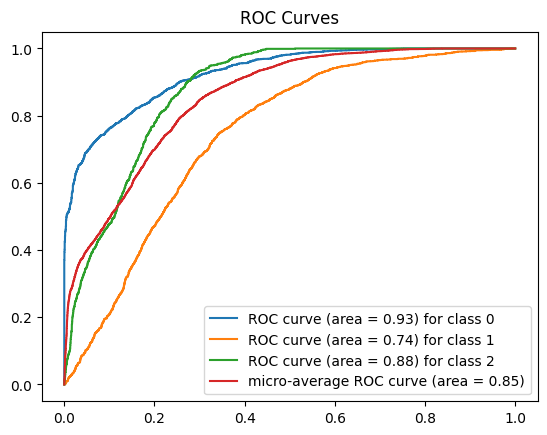

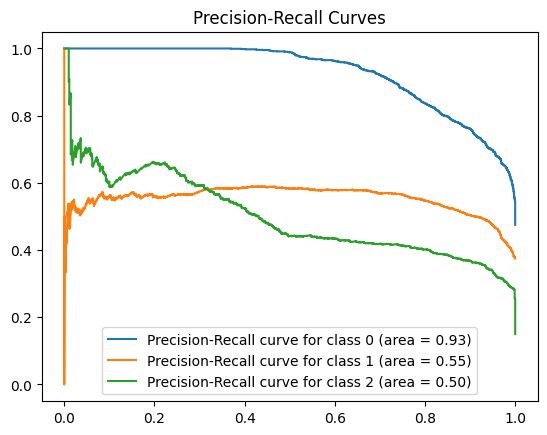

Confusion Matrix: 
 [[2427  348   75]
 [ 576  832  842]
 [  15  269  616]]
Confusion Matrix: 
 [[2427  348   75]
 [ 576  832  842]
 [  15  269  616]]


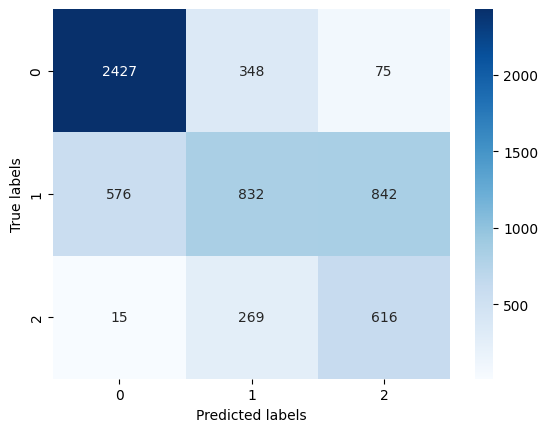

Classification Report: 
               precision    recall  f1-score   support

     Class 0       0.80      0.85      0.83      2850
     Class 1       0.57      0.37      0.45      2250
     Class 2       0.40      0.68      0.51       900

    accuracy                           0.65      6000
   macro avg       0.59      0.64      0.59      6000
weighted avg       0.66      0.65      0.64      6000

Area Under Curve - PR:  {0: 0.9276148952903155, 1: 0.5529019567600126, 2: 0.4998804595324231}
Data type: Metabolomics
X_train shape: (79, 891)
y_train shape: 79
X_test shape: (40, 891)
y_test shape: 40
X_val shape: (79, 891)
y_val shape: 79
Correlation matrix created
Edge list created
Converted to tensor
Graphs created
Correlation matrix created
Edge list created
Converted to tensor
Graphs created
Correlation matrix created
Edge list created
Converted to tensor
Graphs created
Number of graphs: 79
Number of labels: 79
Input dimensions:  1
Epoch: 1, Training Loss: 1.0857, Testing Loss: 1.1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2, Training Loss: 1.0738, Testing Loss: 1.1435, Accuracy: 15.00%
Validation Metrics - Epoch: 2, Accuracy: 0.14%, ROC AUC: 0.67, F1 Macro: 0.08, F1 Weighted: 0.03, Precision: 0.05, Recall: 0.33, Severe Recall: 1.00
Epoch: 3, Training Loss: 0.9814, Testing Loss: 1.1123, Accuracy: 15.00%
Validation Metrics - Epoch: 3, Accuracy: 0.14%, ROC AUC: 0.68, F1 Macro: 0.09, F1 Weighted: 0.04, Precision: 0.05, Recall: 0.33, Severe Recall: 1.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4, Training Loss: 1.0266, Testing Loss: 1.1185, Accuracy: 25.00%
Validation Metrics - Epoch: 4, Accuracy: 0.16%, ROC AUC: 0.68, F1 Macro: 0.12, F1 Weighted: 0.08, Precision: 0.38, Recall: 0.35, Severe Recall: 1.00
Epoch: 5, Training Loss: 1.0547, Testing Loss: 1.1117, Accuracy: 32.50%
Validation Metrics - Epoch: 5, Accuracy: 0.27%, ROC AUC: 0.68, F1 Macro: 0.23, F1 Weighted: 0.24, Precision: 0.39, Recall: 0.42, Severe Recall: 1.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6, Training Loss: 1.0471, Testing Loss: 1.0833, Accuracy: 47.50%
Validation Metrics - Epoch: 6, Accuracy: 0.42%, ROC AUC: 0.69, F1 Macro: 0.37, F1 Weighted: 0.39, Precision: 0.45, Recall: 0.53, Severe Recall: 1.00
Epoch: 7, Training Loss: 1.0476, Testing Loss: 1.0389, Accuracy: 62.50%
Validation Metrics - Epoch: 7, Accuracy: 0.54%, ROC AUC: 0.72, F1 Macro: 0.51, F1 Weighted: 0.58, Precision: 0.54, Recall: 0.54, Severe Recall: 0.55
Epoch: 8, Training Loss: 1.0163, Testing Loss: 0.9894, Accuracy: 80.00%
Validation Metrics - Epoch: 8, Accuracy: 0.62%, ROC AUC: 0.77, F1 Macro: 0.49, F1 Weighted: 0.61, Precision: 0.50, Recall: 0.50, Severe Recall: 0.09
Epoch: 9, Training Loss: 0.9663, Testing Loss: 0.9598, Accuracy: 80.00%
Validation Metrics - Epoch: 9, Accuracy: 0.63%, ROC AUC: 0.78, F1 Macro: 0.46, F1 Weighted: 0.61, Precision: 0.45, Recall: 0.49, Severe Recall: 0.00
Epoch: 10, Training Loss: 1.0620, Testing Loss: 0.9690, Accuracy: 67.50%
Validation Metrics - Epoch: 10, Accuracy: 0

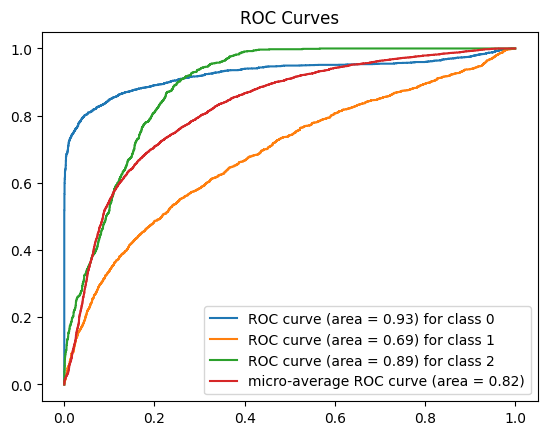

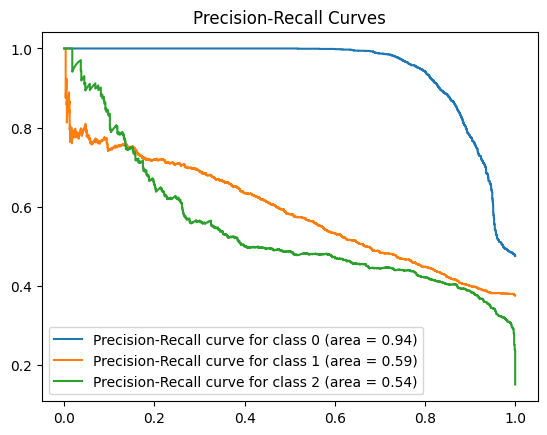

Confusion Matrix: 
 [[2229  314  307]
 [  98 1025 1127]
 [   0   90  810]]
Confusion Matrix: 
 [[2229  314  307]
 [  98 1025 1127]
 [   0   90  810]]


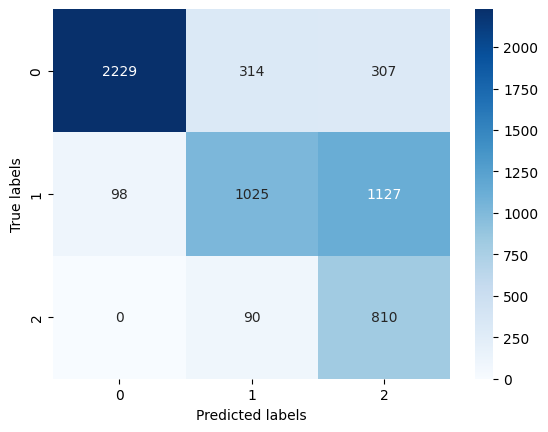

Classification Report: 
               precision    recall  f1-score   support

     Class 0       0.96      0.78      0.86      2850
     Class 1       0.72      0.46      0.56      2250
     Class 2       0.36      0.90      0.52       900

    accuracy                           0.68      6000
   macro avg       0.68      0.71      0.64      6000
weighted avg       0.78      0.68      0.70      6000

Area Under Curve - PR:  {0: 0.9447745813012983, 1: 0.5856662714460674, 2: 0.5414968993252282}


In [15]:
data_paths = [#'/content/X_clinical.pkl',
              'covid_baseline_classifier_outputs/Proteomics',
              'covid_baseline_classifier_outputs/Metabolomics'
              ]
main(data_paths)

In [16]:
!zip -r covid_baseline_gnn_outputs.zip covid_baseline_gnn_outputs

  adding: covid_baseline_gnn_outputs/ (stored 0%)
  adding: covid_baseline_gnn_outputs/.ipynb_checkpoints/ (stored 0%)
  adding: covid_baseline_gnn_outputs/Clinical/ (stored 0%)
  adding: covid_baseline_gnn_outputs/trained_model (2).pkl (deflated 85%)
  adding: covid_baseline_gnn_outputs/Metabolomics/ (stored 0%)
  adding: covid_baseline_gnn_outputs/Metabolomics/graphs_train.pkl (deflated 46%)
  adding: covid_baseline_gnn_outputs/Metabolomics/graphs_val.pkl (deflated 50%)
  adding: covid_baseline_gnn_outputs/Metabolomics/estimators_model.csv (deflated 50%)
  adding: covid_baseline_gnn_outputs/Metabolomics/trained_gnn_model.pkl (deflated 31%)
  adding: covid_baseline_gnn_outputs/Metabolomics/graphs_test.pkl (deflated 37%)
  adding: covid_baseline_gnn_outputs/Proteomics/ (stored 0%)
  adding: covid_baseline_gnn_outputs/Proteomics/graphs_train.pkl (deflated 83%)
  adding: covid_baseline_gnn_outputs/Proteomics/graphs_val.pkl (deflated 84%)
  adding: covid_baseline_gnn_outputs/Proteomics/es

## Stacked Ensemble

In [17]:
metabolomics_input_dim = 1
proteomics_input_dim = 1

metabolomics_gnn_instance = GNN(input_dim=metabolomics_input_dim, num_classes=3)
proteomics_gnn_instance = GNN(input_dim=proteomics_input_dim, num_classes=3)

metabolomics_gnn_instance.load_state_dict(torch.load('/content/covid_baseline_gnn_outputs/Metabolomics/trained_gnn_model.pkl'))
proteomics_gnn_instance.load_state_dict(torch.load('/content/covid_baseline_gnn_outputs/Proteomics/trained_gnn_model.pkl'))

<All keys matched successfully>

In [20]:
metabolomics_gnn_instance.load_state_dict(torch.load('/content/covid_baseline_gnn_outputs/Metabolomics/trained_gnn_model.pkl'))
proteomics_gnn_instance.load_state_dict(torch.load('/content/covid_baseline_gnn_outputs/Proteomics/trained_gnn_model.pkl'))
clinical_model = joblib.load('/content/covid_baseline_gnn_outputs/Clinical/trained_model.pkl')

In [21]:
def load_graphs(file_name):
    return joblib.load(file_name)

In [22]:
metabolomics_graphs_train = load_graphs('/content/covid_baseline_gnn_outputs/Metabolomics/graphs_train.pkl')
metabolomics_graphs_test = load_graphs('/content/covid_baseline_gnn_outputs/Metabolomics/graphs_test.pkl')
metabolomics_graphs_val = load_graphs('/content/covid_baseline_gnn_outputs/Metabolomics/graphs_val.pkl')

proteomics_graphs_train = load_graphs('/content/covid_baseline_gnn_outputs/Proteomics/graphs_train.pkl')
proteomics_graphs_test = load_graphs('/content/covid_baseline_gnn_outputs/Proteomics/graphs_test.pkl')
proteomics_graphs_val = load_graphs('/content/covid_baseline_gnn_outputs/Proteomics/graphs_val.pkl')

In [24]:
clinical_X_train = joblib.load('/content/covid_baseline_gnn_outputs/Clinical/X_clinical.pkl')
clinical_y_train = joblib.load('/content/covid_baseline_gnn_outputs/Clinical/y_train.pkl')
clinical_X_test = joblib.load('/content/covid_baseline_gnn_outputs/Clinical/X_test.pkl')
clinical_y_test = joblib.load('/content/covid_baseline_gnn_outputs/Clinical/y_test.pkl')
clinical_X_val = joblib.load('/content/covid_baseline_gnn_outputs/Clinical/X_val.pkl')
clinical_y_val = joblib.load('/content/covid_baseline_gnn_outputs/Clinical/y_val.pkl')

In [25]:
import torch
from sklearn.base import BaseEstimator, ClassifierMixin

class CustomGNNModel(BaseEstimator, ClassifierMixin):
    def __init__(self, model, graphs_train=None, graphs_test=None, graphs_val=None):
        self.model = model
        self.graphs_train = graphs_train
        self.graphs_test = graphs_test
        self.graphs_val = graphs_val

    def fit(self, X, y=None):
        self.classes_ = np.unique(y) if y is not None else None
        return self

    def predict(self, X):
        if self.graphs_train is not None and len(X) == len(self.graphs_train):
            graphs = self.graphs_train
        elif self.graphs_val is not None and len(X) == len(self.graphs_val):
            graphs = self.graphs_val
        elif self.graphs_test is not None:
            graphs = self.graphs_test
        else:
            raise ValueError("No matching graph set found for the input data.")


        self.model.eval()
        predictions = []
        with torch.no_grad():
            for graph in graphs:
                out = self.model(graph)
                pred = out.argmax(dim=1)
                predictions.append(pred)
        return torch.cat(predictions).cpu().numpy()

    def predict_proba(self, X):
        if self.graphs_train is not None and len(X) == len(self.graphs_train):
            graphs = self.graphs_train
        elif self.graphs_val is not None and len(X) == len(self.graphs_val):
            graphs = self.graphs_val
        elif self.graphs_test is not None:
            graphs = self.graphs_test
        else:
            raise ValueError("No matching graph set found for the input data.")

        self.model.eval()
        probabilities = []
        with torch.no_grad():
            for graph in graphs:
                out = self.model(graph)
                prob = torch.softmax(out, dim=1)
                probabilities.append(prob)
        return torch.cat(probabilities).cpu().numpy()

    def get_params(self, deep=True):
        return {"model": self.model, "graphs_train": self.graphs_train, "graphs_test": self.graphs_test}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self



class CustomMLModel(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y=None):
        self.model.fit(X, y)
        self.classes_ = np.unique(y)
        return self

    def predict_proba(self, X):
        return self.model.predict_proba(X)

    def predict(self, X):
        return self.model.predict(X)


In [26]:
metabolomics_wrapper = CustomGNNModel(metabolomics_gnn_instance, metabolomics_graphs_train, metabolomics_graphs_test)
proteomics_wrapper = CustomGNNModel(proteomics_gnn_instance, proteomics_graphs_train, proteomics_graphs_test)
clinical_wrapper = CustomMLModel(model=clinical_model)

In [27]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [28]:
base_models = [
    ('metabolomics', metabolomics_wrapper),
    ('proteomics', proteomics_wrapper),
    ('clinical', clinical_wrapper),
]

#stacked_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())
stacked_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())

X_dummy = np.zeros(len(clinical_y_train)).reshape(-1, 1)

X_dummy_test = np.zeros(len(clinical_y_test)).reshape(-1, 1)
X_dummy_val = np.zeros(len(clinical_y_val)).reshape(-1, 1)

stacked_model.fit(X_dummy, clinical_y_train)

StackingClassifier(estimators=[('metabolomics',
                                CustomGNNModel(graphs_test=[Data(x=[891, 1], edge_index=[2, 74]),
                                                            Data(x=[891, 1], edge_index=[2, 74]),
                                                            Data(x=[891, 1], edge_index=[2, 74]),
                                                            Data(x=[891, 1], edge_index=[2, 74]),
                                                            Data(x=[891, 1], edge_index=[2, 74]),
                                                            Data(x=[891, 1], edge_index=[2, 74]),
                                                            Data(x=[891, 1], edge_index=[2, 74]),
                                                            Data(x=[891, 1], edge_index=[2, 74]),
                                                            Dat...
                                                             Data(x=[454, 1], edge_index=[2, 535]),
                                                             Data(x=[454, 1], edge_index=[2, 535]), ...],
                                               model=GNN(
  (conv1): GraphConv(1, 16)
  (conv2): GraphConv(16, 32)
  (fc): Linear(in_features=32, out_features=3, bias=True)
))),
                               ('clinical',
                                CustomMLModel(model=RandomForestClassifier(criterion='entropy',
                                                                           max_depth=20,
                                                                           min_samples_leaf=2,
                                                                           min_samples_split=10,
                                                                           n_estimators=50)))],
                   final_estimator=LogisticRegression())

In [29]:
rf_params = {
    'final_estimator__n_estimators': [100, 200, 300],
    'final_estimator__max_depth': [None, 10, 20],
    'final_estimator__min_samples_split': [2, 5, 10]
}
svc_params = {
    'final_estimator__C': [0.1, 1, 2, 3, 4, 5, 10],
    'final_estimator__gamma': ['scale', 'auto'],
    'final_estimator__kernel': ['linear', 'rbf']
}
et_params = {
    'final_estimator__n_estimators': [100, 200, 300],
    'final_estimator__max_depth': [None, 10, 20],
    'final_estimator__min_samples_split': [2, 5, 10]
}

In [32]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

stacked_model = StackingClassifier(estimators=base_models, final_estimator=ExtraTreesClassifier())

grid_search = GridSearchCV(estimator=stacked_model, param_grid=et_params, cv=20, scoring='accuracy')
grid_search.fit(X_dummy, clinical_y_train)

print("Best parameters for Extra Trees:", grid_search.best_params_)
print("Best score for Extra Trees:", grid_search.best_score_)

Streaming output truncated to the last 5000 lines.
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_stacking.py", line 142, in _concatenate_predictions
    return np.hstack(X_meta)
  File "<__array_function__ internals>", line 180, in hstack
  File "/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py", line 345, in hstack
    return _nx.concatenate(arrs, 1)
  File "<__array_function__ internals>", line 180, in concatenate
ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 40 and the array at index 2 has size 4

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _sco

Best parameters for Extra Trees: {'final_estimator__max_depth': None, 'final_estimator__min_samples_split': 2, 'final_estimator__n_estimators': 100}
Best score for Extra Trees: nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy with SVC: 40.00%
Val Accuracy with SVC: 44.30%
Test Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.47      0.46        19
           1       0.36      0.33      0.34        15
           2       0.33      0.33      0.33         6

    accuracy                           0.40        40
   macro avg       0.38      0.38      0.38        40
weighted avg       0.40      0.40      0.40        40



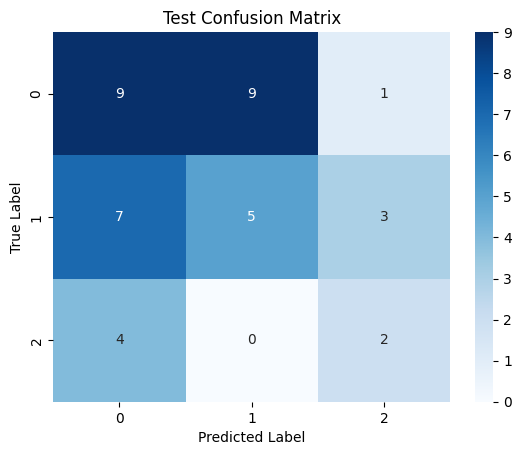

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.54      0.50        37
           1       0.42      0.48      0.45        31
           2       0.00      0.00      0.00        11

    accuracy                           0.44        79
   macro avg       0.29      0.34      0.32        79
weighted avg       0.38      0.44      0.41        79



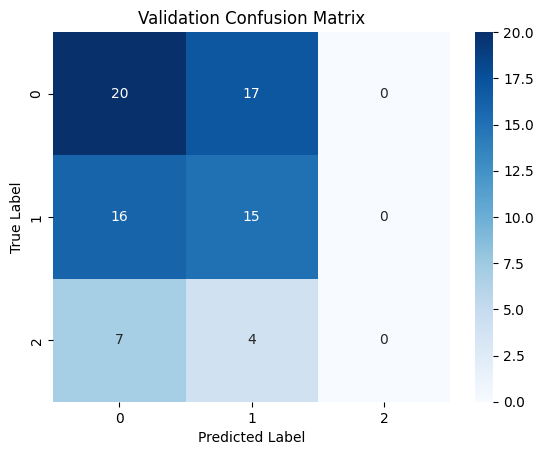

In [37]:
best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(X_dummy_test)
y_pred_proba_test = best_model.predict_proba(X_dummy_test)
y_pred_val = best_model.predict(X_dummy_val)
y_pred_proba_val = best_model.predict_proba(X_dummy_val)

test_accuracy = accuracy_score(clinical_y_test, y_pred_test)
val_accuracy = accuracy_score(clinical_y_val, y_pred_val)
roc_auc = roc_auc_score(clinical_y_test, y_pred_proba_test, multi_class='ovr')
roc_auc_val = roc_auc_score(clinical_y_val, y_pred_proba_val, multi_class='ovr')
fscore_macro = f1_score(clinical_y_test, y_pred_test, average='macro')
fscore_macro_val = f1_score(clinical_y_val, y_pred_val, average='macro')
fscore_weighted = f1_score(clinical_y_test, y_pred_test, average='weighted')
fscore_weighted_val = f1_score(clinical_y_val, y_pred_val, average='weighted')
precision = precision_score(clinical_y_test, y_pred_test, average='macro')
precision_val = precision_score(clinical_y_val, y_pred_val, average='macro')
recall = recall_score(clinical_y_test, y_pred_test, average='macro')
recall_val = recall_score(clinical_y_val, y_pred_val, average='macro')
recall_severe = recall_score(clinical_y_test, y_pred_test, labels=[2], average='macro')
recall_severe_val = recall_score(clinical_y_val, y_pred_val, labels=[2], average='macro')

estimators_model = pd.DataFrame()
estimators_model['Models'] = ['Stacking Ensemble Model']
estimators_model['ROC AUC'] = [roc_auc]
estimators_model['ROC AUC Validation'] = [roc_auc_val]
estimators_model['F1-score (macro)'] = [fscore_macro]
estimators_model['F1-score (macro) Validation'] = [fscore_macro_val]
estimators_model['F1-score (weighted)'] = [fscore_weighted]
estimators_model['F1-score (weighted) Validation'] = [fscore_weighted_val]
estimators_model['Precision'] = [precision]
estimators_model['Precision Validation'] = [precision_val]
estimators_model['Recall'] = [recall]
estimators_model['Recall Validation'] = [recall_val]
estimators_model['Recall Severe'] = [recall_severe]
estimators_model['Recall Severe Validation'] = [recall_severe_val]
estimators_model['Score'] = [test_accuracy]
estimators_model['Score Validation'] = [val_accuracy]
print(f"Test Accuracy with SVC: {test_accuracy:.2%}")
print(f"Val Accuracy with SVC: {val_accuracy:.2%}")

print("Test Classification Report:\n", classification_report(clinical_y_test, y_pred_test))

cm = confusion_matrix(clinical_y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.title('Test Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("Validation Classification Report:\n", classification_report(clinical_y_val, y_pred_val))

cm = confusion_matrix(clinical_y_val, y_pred_val)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.title('Validation Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [34]:
estimators_model.to_excel('stacked_model_results.xlsx')

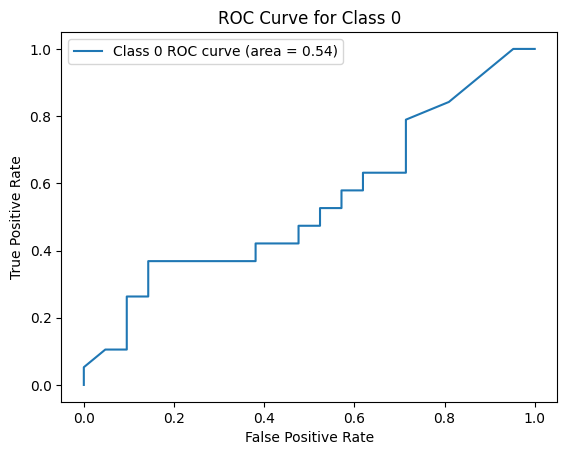

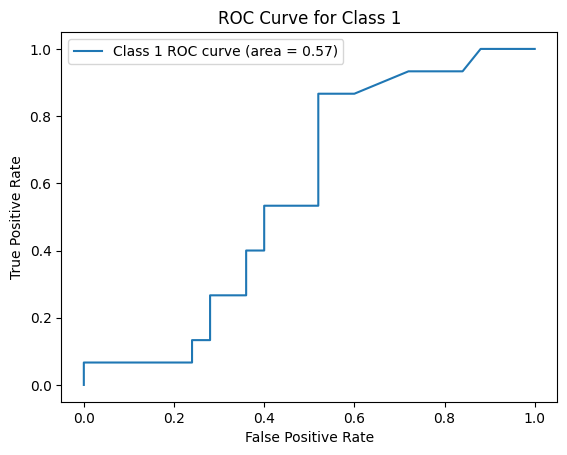

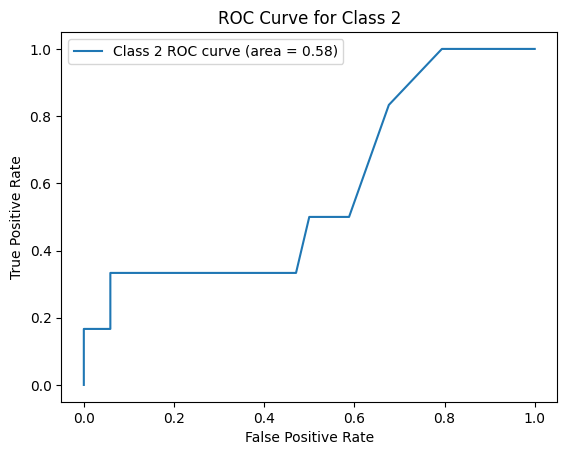

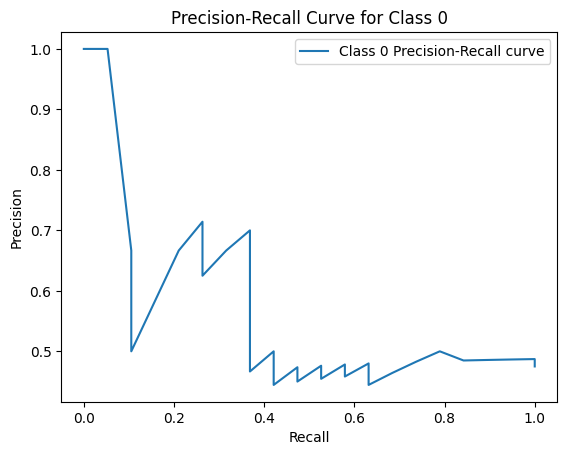

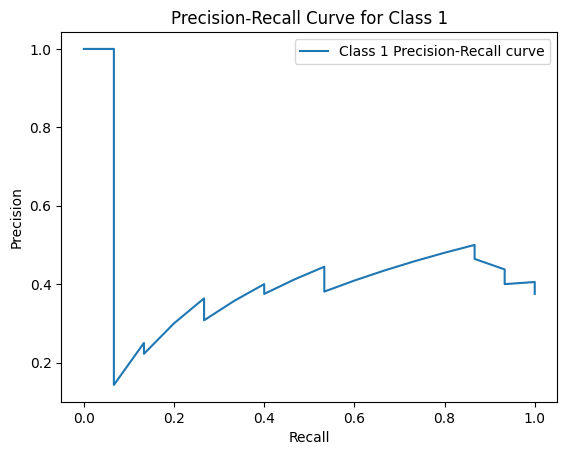

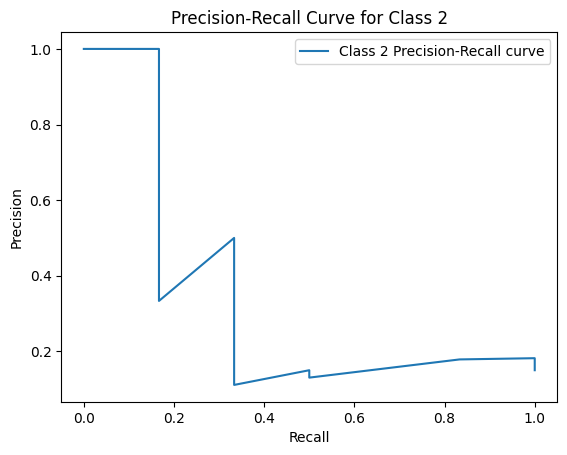

In [35]:
n_classes = len(np.unique(clinical_y_test))
clinical_y_test_binarized = label_binarize(clinical_y_test, classes=range(n_classes))

fpr, tpr, roc_auc = dict(), dict(), dict()
precision, recall = dict(), dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(clinical_y_test_binarized[:, i], y_pred_proba_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    precision[i], recall[i], _ = precision_recall_curve(clinical_y_test_binarized[:, i], y_pred_proba_test[:, i])


for i in range(3):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label=f'Class {i} ROC curve (area = {roc_auc[i]:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Class {i}')
    plt.legend(loc='best')
    plt.show()

for i in range(3):
    plt.figure()
    plt.plot(recall[i], precision[i], label=f'Class {i} Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for Class {i}')
    plt.legend(loc='best')
    plt.show()